In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9382716049382716, Loss: 0.34788502587212455
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.17529296875
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.18297190136379665
Checkpoint 400, Accuracy: 0.9753086419753086, Loss: 0.16189917811640986
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.17452059851752388


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8870016  0.04515574 0.06784264]
[1. 0. 0.] <-> [0.9444897  0.0193802  0.03613004]
[1. 0. 0.] <-> [0.8654826  0.11204641 0.02247101]
[1. 0. 0.] <-> [0.9158725  0.03128459 0.05284291]
[1. 0. 0.] <-> [0.93006265 0.04175704 0.0281803 ]
[0. 1. 0.] <-> [0.14888318 0.8386505  0.01246626]
[1. 0. 0.] <-> [0.9037329  0.04201391 0.05425317]
[1. 0. 0.] <-> [0.77932453 0.03937979 0.18129565]
[1. 0. 0.] <-> [0.813428   0.17329545 0.01327648]
[1. 0. 0.] <-> [0.9113209  0.05787484 0.03080419]
[1. 0. 0.] <-> [0.88832295 0.09141411 0.020263  ]
[1. 0. 0.] <-> [0.9188395  0.03760996 0.04355046]
[1. 0. 0.] <-> [0.9615646  0.01877617 0.01965919]
[1. 0. 0.] <-> [0.9581906  0.02446999 0.01733935]
[1. 0. 0.] <-> [0.87728417 0.05771163 0.06500414]
[0. 1. 0.] <-> [0.0566634  0.93551856 0.00781805]
[1. 0. 0.] <-> [0.922449  0.0230713 0.0544797]
[1. 0. 0.] <-> [0.93718415 0.03748482 0.02533098]
[1. 0. 0.] <-> [0.9320951  0.05744684 0.01045809]
[0. 0. 1.] <-> [0.04771201 0.02350457 0.92878336]
[1.

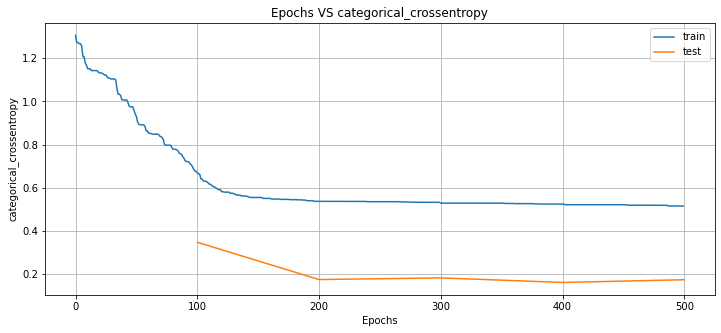

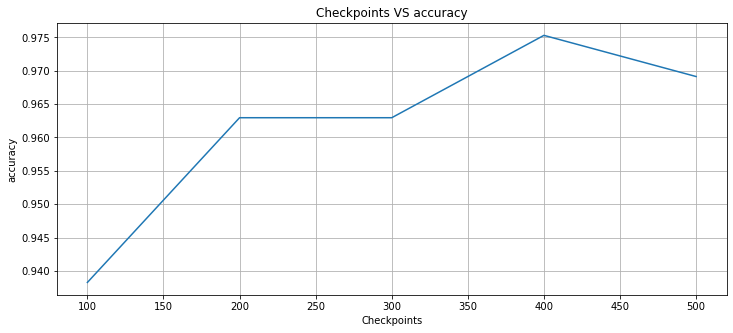

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9382716049382716, 'mean_square_error': 0.1688461541784202, 'categorical_crossentropy': 0.34788502587212455, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 9, 'tn_hit': 19, 'fn_hit': 1}, 1: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 7}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.08240556505170991, 'categorical_crossentropy': 0.17529296875, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 5, 'tn_hit': 23, 'fn_hit': 1}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.08290988237898132, 'categorical_crossentropy': 0.18297190136379665, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 5, 'tn_hit': 23, 'fn_hit': 1}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-1.0959284   2.3141007   1.1837821  -0.06272054  0.05760007]
 bias: -1.3889421224594116

Neuron 1: weights:
[-0.1155419   1.877319    0.02894177 -0.32740915 -1.0896052 ]
 bias: 0.9837749004364014

Neuron 2: weights:
[ 0.03203661 -0.599       0.00622054  0.9264302   1.4599147 ]
 bias: -0.017535334452986717

Neuron 3: weights:
[-0.0252564  -0.52239895 -0.47764713 -1.186667   -0.05001651]
 bias: 0.021990759298205376

$
Layer 2
Neuron 0: weights:
[-3.         2.1613972 -0.6062906  3.       ]
 bias: -0.03816647082567215

Neuron 1: weights:
[ 3.0000000e+00 -1.1482506e-04 -4.4238073e-01 -9.7341633e-01]
 bias: 0.0806346908211708

Neuron 2: weights:
[-0.19587085 -2.5116832   3.         -0.054739  ]
 bias: 0.1046028882265091

$

